In [1]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

In [2]:
cifar10_builder = tfds.builder("cifar10")

In [3]:
cifar10_builder.download_and_prepare()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteVF0EN3/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteVF0EN3/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [4]:
cifar10_train = cifar10_builder.as_dataset(split="train")
cifar10_test = cifar10_builder.as_dataset(split="test")

In [5]:
cifar10_train.take(1)

<_TakeDataset element_spec={'id': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [6]:
def flatten_image(x, label=False):
    if label:
        return (tf.divide(
            tf.dtypes.cast(
                tf.reshape(x["image"], (1, 32*32*3)), tf.float32), 256.0),
                x["label"])
    else:
        return (
            tf.divide(tf.dtypes.cast(
                tf.reshape(x["image"], (1, 32*32*3)), tf.float32), 256.0))

Label: 7


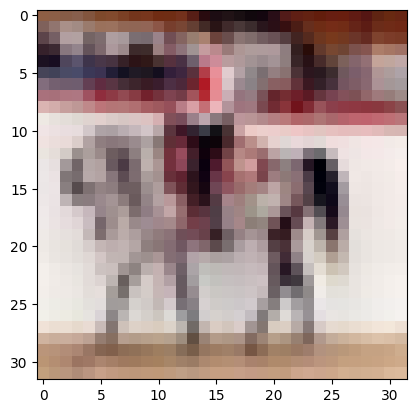

In [7]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

for sample in cifar10_train.map(lambda x: flatten_image(x, label=True)).take(1):
    plt.imshow(sample[0].numpy().reshape(32,32,3).astype(np.float32),
               cmap=plt.get_cmap("gray")
              )
    print("Label: %d" % sample[1].numpy())

In [8]:
class VAE(tf.keras.Model):

    def __init__(self, input_shape, name='variational_autoencoder',
                 latent_dim=10, hidden_dim=10, encoder='GaussianMLP',
                 decoder='BernoulliMLP', iaf_model=None,
                 number_iaf_networks=0, iaf_params={},
                 num_samples=100, **kwargs):
        super().__init__(name=name, **kwargs)
        self._latent_dim = latent_dim
        self._num_samples = num_samples
        self._iaf = []

        if encoder == 'GaussianMLP':
            self._encoder = GaussianMLP(input_shape=input_shape,
                                        latent_dim=latent_dim,
                                        iaf=(iaf_model is not None),
                                        hidden_dim=hidden_dim)
        else:
            raise ValueError("Unknown encoder type: {}".format(encoder))

        if decoder == 'BernoulliMLP':
            self._decoder = BernoulliMLP(input_shape=(1, latent_dim),
                                         latent_dim=input_shape[1],
                                         hidden_dim=hidden_dim)
        elif decoder == 'GaussianMLP':
            self._decoder = GaussianMLP(input_shape=(1, latent_dim),
                                         latent_dim=input_shape[1],
                                         iaf=(iaf_model is not None),
                                         hidden_dim=hidden_dim)
        else:
            raise ValueError("Unknown decoder type: {}".format(decoder))

        if iaf_model:
            self._iaf = []
            for t in range(number_iaf_networks):
                self._iaf.append(
                    iaf_model(input_shape=(1, latent_dim*2), **iaf_params)
                )

    @tf.function
    def sample(self, eps=None):
        if eps is None:
            eps = tf.random.normal(shape=(self._num_samples, self.latent_dim))
        return self._decoder.call(eps, apply_sigmoid=False)

    def encode(self, x):
        return self._encoder.call(x)

    def decode(self, z, apply_sigmoid=True):
      logits, _, _ = self._decoder.call(z)

      if apply_sigmoid is True:
          probs = tf.sigmoid(logits)
          return probs

      return logits

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    @property
    def iaf(self):
        return self._iaf

In [9]:
import tensorflow_probability as tfp

class GaussianMLP(tf.keras.Model):

    def __init__(self, input_shape, name='GaussianMLP', hidden_dim=10, latent_dim=10, iaf=False, **kwargs):
        super().__init__(name=name, **kwargs)
        self._h = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self._mean = tf.keras.layers.Dense(latent_dim)
        self._logvar = tf.keras.layers.Dense(latent_dim)
        self._iaf_output = None
        if iaf:
            self._iaf_output = tf.keras.layers.Dense(latent_dim)

    def call(self, x):
        if self._iaf_output:
            return self._mean(self._h(x)), self._logvar(self._h(x)), self._iaf_output(self._h(x))
        else:
            return self._mean(self._h(x)), self._logvar(self._h(x)), None

In [10]:
class BernoulliMLP(tf.keras.Model):

    def __init__(self, input_shape, name='BernoulliMLP', hidden_dim=10, latent_dim=10, **kwargs):
        super().__init__(name=name, **kwargs)

        self._h = tf.keras.layers.Dense(hidden_dim, activation='tanh')
        self._y = tf.keras.layers.Dense(latent_dim, activation='sigmoid')

    def call(self, x):

        return self._y(self._h(x)), None, None

In [11]:
# model = VAE(input_shape=(1,3072), hidden_dim=500, latent_dim=500)
model = VAE(input_shape=(1,3072), hidden_dim=500, latent_dim=500, iaf_model=GaussianMLP, number_iaf_networks=3, iaf_params={'latent_dim': 500, 'hidden_dim': 500, 'iaf': False})

In [12]:
def log_normal_pdf(sample, mean, logvar, raxis=1):
    log2pi = tf.math.log(2. * np.pi)
    return tf.reduce_sum(
          -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
          axis=raxis)

@tf.function
def compute_loss(model, x):
    mean, logvar, h = model.encode(x)
    z = model.reparameterize(mean, logvar)

    logqz_x = log_normal_pdf(z, mean, logvar)

    for iaf_model in model.iaf:
        mean, logvar, _ = iaf_model.call(tf.concat([z, h], 2))
        s = tf.sigmoid(logvar)
        z = tf.add(tf.math.multiply(z,s), tf.math.multiply(mean,(1-s)))
        logqz_x -= tf.reduce_sum(tf.math.log(s))

    x_logit = model.decode(z)
    cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
    logpx_z = -tf.reduce_sum(cross_ent, axis=[2])
    logpz = log_normal_pdf(z, 0., 0.)

    return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def compute_apply_gradients(model, x, optimizer):
    with tf.GradientTape() as tape:
        loss = compute_loss(model, x)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [ ]:
import time as time

epochs = 100
optimizer = tf.keras.optimizers.Adam(1e-4)

for epoch in range(1, epochs + 1):
    start_time = time.time()
    for train_x in cifar10_train.map(
            lambda x: flatten_image(x, label=False)).batch(32):
        compute_apply_gradients(model, train_x, optimizer)
    end_time = time.time()

    if epoch % 1 == 0:
        loss = tf.keras.metrics.Mean()
        for test_x in cifar10_test.map(
            lambda x: flatten_image(x, label=False)).batch(32):
            loss(compute_loss(model, test_x))
    elbo = -loss.result()
    print('Epoch: {}, Test set ELBO: {}, '
          'time elapse for current epoch {}'.format(epoch, elbo, end_time - start_time))

Epoch: 1, Test set ELBO: -2286.434814453125, time elapse for current epoch 194.65358066558838
Epoch: 2, Test set ELBO: -2269.20947265625, time elapse for current epoch 185.88923525810242
Epoch: 3, Test set ELBO: -2265.390869140625, time elapse for current epoch 189.828950881958
Epoch: 4, Test set ELBO: -2264.124267578125, time elapse for current epoch 187.77829480171204


In [ ]:
i = 0

# change the number in ".take(x)" to adjust the number of images displayed
for sample in cifar10_train.map(lambda x: flatten_image(x, label=False)).batch(1).take(3):
    mean, logvar, h = model.encode(sample)
    z = model.reparameterize(mean, logvar)

    for iaf_model in model.iaf:
        mean, logvar, _ = iaf_model.call(tf.concat([z, h], 2))
        s = tf.sigmoid(logvar)
        z = tf.add(tf.math.multiply(z, s), tf.math.multiply(mean, (1 - s)))

    # Create a new figure with subplots
    plt.figure(i, figsize=(10, 5))

    # Plot the original sample
    plt.subplot(1, 2, 1)
    plt.imshow((sample.numpy().reshape(32, 32, 3)).astype(np.float32), cmap=plt.get_cmap("gray"))

    # Plot the reconstructed image
    plt.subplot(1, 2, 2)
    plt.imshow((model.decode(z).numpy().reshape(32, 32, 3)).astype(np.float32), cmap=plt.get_cmap("gray"))

    i += 1

In [ ]:
z = np.random.normal(size=(1,500))
h = np.random.normal(size=(1,500))

for iaf_model in model.iaf:
    mean, logvar, _ = iaf_model.call(tf.concat([z, h], 1))
    s = tf.sigmoid(logvar)
    z = tf.add(tf.math.multiply(z,s), tf.math.multiply(mean,(1-s)))

plt.imshow((model.decode(z).numpy().reshape(32,32,3)).astype(np.float32), cmap=plt.get_cmap("gray"))
# plt.imshow((model.sample(10).numpy().reshape(32, 32, 3)).astype(np.float32), cmap=plt.get_cmap("gray"))

In [ ]:
g = GaussianMLP(input_shape=(1,3072), hidden_dim=10, latent_dim=10)

In [ ]:
b = BernoulliMLP(input_shape=(1,3072), hidden_dim=10, latent_dim=10)

In [ ]:
for image in cifar10_train.map(lambda x: flatten_image(x, label=False)).take(10):
    print(g.call(image))

In [ ]:
!pip3 install pydot
!pip3 install graphviz

In [ ]:
!pip install tensorflow

In [ ]:
import pydot
import graphviz

from tensorflow.keras.utils import plot_model

In [ ]:
# Build the model (specify input shape)
g.build(input_shape=(None, 1, 3072))

# Plot the model
plot_model(g, show_shapes=True, show_layer_names=True)